# Итоговый анализ и сегментация заказчиков для маркетплейса Supl.biz

### **Часть 1: Описание проекта и подготовка данных**

#### **1.1. Бизнес-контекст и цели**
**Бизнес-цель:** Помочь поставщикам на маркетплейсе принимать более обоснованные решения за счет выявления наиболее перспективных клиентов и понимания их потребностей.

**Цель исследования:**
*   Разделить клиентскую базу на 3-5 сегментов по их поведению.
*   Определить ключевые факторы, влияющие на выбор поставщика.
*   Сформулировать перечень измеримых показателей для оценки перспективности заказчиков.

**Инструменты анализа:** Python 3, Pandas, Scikit-learn, Matplotlib, Seaborn.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- 1.2. Загрузка библиотек и данных ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Настройки для лучшего отображения графиков
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
# Загрузка данных
path = '/content/drive/MyDrive/Colab Notebooks/Стажировка/taskSupl.csv'
df = pd.read_csv(path, encoding='utf-8')
# Первичный осмотр
print("\n--- Первые 5 строк датасета ---")
display(df.head())
print("\n--- Общая информация о датасете ---")
df.info()


--- Первые 5 строк датасета ---


,Заказчик,Дата заказа,Заголовок заказа,Описание заказа,Размер заказа,Рубрики,Регионы,Город поставки,Победившая компания,Город победителя,Закрыт ли заказ
0,2260116,30-04-2025 09:55,Требуется листовой чай для продажи на маркетпл...,Требуется листовой чай для продажи на маркетпл...,Мелкий,Травяной чай,"Северо-Западный федеральный округ, Центральный...",Краснодар,"ООО ""ЧАЙНЫЙ ЛИСТ""",Москва,Да
1,2316696,07-04-2025 06:11,Требуется производство по пошиву одежды из дже...,Требуется производство по пошиву одежды из дже...,Крупный,Женская одежда,Кыргызстан,Санкт-Петербург,ТОО «TWINS TEXTILE (ТВИНС ТЕКСТИЛЬ)»,Алматы,Да
2,2312826,01-04-2025 13:28,Требуется мебель корпусная в ассортименте для ...,Требуется мебель корпусная в ассортименте для ...,Мелкий,Мебель корпусная,"Приволжский федеральный округ, Центральный фед...",Таганрог,ИП Торопцева Мария Петровна,Пенза,Да
3,2306581,02-03-2025 20:56,Требуются Wi-Fi роутеры для продажи на маркетп...,Требуются Wi-Fi роутеры для продажи на маркетп...,Средний,Маршрутизаторы,"Приволжский федеральный округ, Нижегородская о...",Нижний Новгород,"ТД ""СИМА-ЛЕНД"" (ООО ""СИМАОПТ"")",Екатеринбург,Да
4,2303600,20-02-2025 04:00,Требуются запчасти для грузовых автомобилей дл...,Требуются запчасти для грузовых автомобилей дл...,Крупный,Автозапчасти для грузовых автомобилей,"Дальневосточный федеральный округ, Сибирский ф...",Новосибирск,"ООО ""ЭВЕРЕСТ""",Хабаровск,Да



--- Общая информация о датасете ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Заказчик             193 non-null    int64 
 1   Дата заказа          193 non-null    object
 2   Заголовок заказа     193 non-null    object
 3   Описание заказа      193 non-null    object
 4   Размер заказа        193 non-null    object
 5   Рубрики              193 non-null    object
 6   Регионы              193 non-null    object
 7   Город поставки       193 non-null    object
 8   Победившая компания  172 non-null    object
 9   Город победителя     190 non-null    object
 10  Закрыт ли заказ      193 non-null    object
dtypes: int64(1), object(10)
memory usage: 16.7+ KB


#### **1.3. Инжиниринг признаков и обработка данных**
Первоначальные данные требовали серьезной подготовки. Ключевая информация (сумма заказа) находилась внутри текстовых полей, а товарные категории были слишком детализированы. Были выполнены следующие шаги:

1.  **Преобразование типов:** Столбец с датой был переведен в формат `datetime`.
2.  **Извлечение суммы:** Написана функция для извлечения суммы заказа из текста. **40% пропусков** в суммах были заполнены **медианным значением (50 000 руб.)**. Это было сделано для сохранения всей клиентской базы и позволило судить о клиентах с неизвестной суммой по другим, поведенческим факторам.

In [ ]:
# --- 1.3.1. Функции и применение ---
df['Дата заказа'] = pd.to_datetime(df['Дата заказа'], format='%d-%m-%Y %H:%M')

def extract_sum_v2(description):
    description_lower = description.lower()
    match = re.search(r'(\d[\d\s]*)\s*руб', description_lower)
    if match: sum_str = match.group(1).replace(' ', '').replace('\xa0', ''); return int(sum_str)
    match = re.search(r'(?:бюджет|от|до)\s*([\d\s,]+)\s*(?:тыс|тысяч)', description_lower)
    if match: sum_str = match.group(1).replace(' ', '').replace(',', '.'); return int(float(sum_str) * 1000)
    match = re.search(r'(?:сумма|бюджет)\s*(?:от|до)?\s*(\d[\d\s]*)', description_lower)
    if match: sum_str = match.group(1).replace(' ', '').replace('\xa0', ''); return int(sum_str)
    return np.nan

df['Сумма заказа'] = df['Описание заказа'].apply(extract_sum_v2)
median_sum = df['Сумма заказа'].median()
df['Сумма заказа'] = df['Сумма заказа'].fillna(median_sum)

size_map = {'Мелкий': 1, 'Средний': 2, 'Крупный': 3}
df['Размер заказа (число)'] = df['Размер заказа'].apply(lambda x: size_map.get(x, 0))

print(f"Пропуски в 'Сумма заказа' успешно заполнены медианным значением: {median_sum}")

Пропуски в 'Сумма заказа' успешно заполнены медианным значением: 50000.0


#### **1.4. Нормализация товарных категорий**
Для повышения качества анализа 98 исходных, часто пересекающихся, товарных категорий были проанализированы и укрупнены до 28 уникальных, логически связанных групп. Этот шаг был критически важен для выявления реальных закономерностей в спросе.

In [ ]:
# --- 1.4.1. Код нормализации ---
category_map = { 'одежд': 'Одежда и аксессуары', 'обувь': 'Одежда и аксессуары', 'белье': 'Одежда и аксессуары', 'бельё': 'Одежда и аксессуары', 'чулочно-носочные': 'Одежда и аксессуары', 'головные уборы': 'Одежда и аксессуары', 'сумки': 'Одежда и аксессуары', 'рюкзаки': 'Одежда и аксессуары', 'трикотаж': 'Одежда и аксессуары', 'хозяйственные': 'Товары для дома и быта', 'бытовая химия': 'Товары для дома и быта', 'уборки': 'Товары для дома и быта', 'посуда': 'Товары для дома и быта', 'кухонные': 'Товары для дома и быта', 'полотенца': 'Товары для дома и быта', 'постельные': 'Товары для дома и быта', 'интерьера': 'Товары для дома и быта', 'светильники': 'Товары для дома и быта', 'гигиены': 'Товары для дома и быта', 'мыло': 'Товары для дома и быта', 'карнизы': 'Товары для дома и быта', 'автозапчасти': 'Автотовары', 'автоаксессуары': 'Автотовары', 'автомасло': 'Автотовары', 'автоароматизатор': 'Автотовары', 'диски колесные': 'Автотовары', 'косметика': 'Красота и здоровье', 'парфюмерия': 'Красота и здоровье', 'ухода за волосами': 'Красота и здоровье', 'маникюрное': 'Красота и здоровье', 'фены': 'Красота и здоровье', 'бад': 'Красота и здоровье', 'медицинские': 'Красота и здоровье', 'игрушки': 'Детские товары', 'детская': 'Одежда и аксессуары', 'новорожденных': 'Детские товары', 'подгузники': 'Детские товары', 'спортивная': 'Спорт и туризм', 'спортивное': 'Спорт и туризм', 'туризма': 'Спорт и туризм', 'спальники': 'Спорт и туризм', 'зоотовары': 'Зоотовары', 'корм для животных': 'Зоотовары', 'мобильные телефоны': 'Электроника и аксессуары', 'apple': 'Электроника и аксессуары', 'маршрутизаторы': 'Электроника и аксессуары', 'наушники': 'Электроника и аксессуары', 'климатическое': 'Электроника и аксессуары', 'элементы питания': 'Электроника и аксессуары', 'игровые консоли': 'Электроника и аксессуары', 'мебель': 'Мебель', 'чай': 'Продукты питания', 'кофе': 'Продукты питания', 'картофель': 'Продукты питания', 'мандарины': 'Продукты питания', 'бензоинструмент': 'Строительство и ремонт', 'крепежные изделия': 'Строительство и ремонт', 'пена монтажная': 'Строительство и ремонт', 'заборы и ограждения': 'Строительство и ремонт'}
def normalize_category(category_name):
    category_name_lower = category_name.lower()
    for key, value in category_map.items():
        if key in category_name_lower: return value
    return category_name
df['Рубрики'] = df['Рубрики'].apply(normalize_category)
print(f"Количество категорий успешно сокращено с 98 до {df['Рубрики'].nunique()}")

Количество категорий успешно сокращено с 98 до 28


#### **1.5. Создание агрегированного профиля клиента**
На основе обработанных данных была создана агрегированная таблица `customers_df`, где для каждого уникального заказчика были рассчитаны ключевые метрики его поведения. Эта таблица стала фундаментом для сегментации.

In [ ]:
# --- 1.5.1. Код агрегации ---
customers_df = df.groupby('Заказчик').agg(
    total_sum=('Сумма заказа', 'sum'),
    orders_count=('Заказчик', 'count'),
    unique_categories=('Рубрики', 'nunique'),
    first_order_date=('Дата заказа', 'min'),
    last_order_date=('Дата заказа', 'max')
).reset_index()

customers_df['days_active'] = (customers_df['last_order_date'] - customers_df['first_order_date']).dt.days + 1
customers_df['purchase_frequency_days'] = customers_df['days_active'] / customers_df['orders_count']

customer_locations = df.groupby('Заказчик')['Город поставки'].agg(lambda x: x.mode()).reset_index()
customers_df = pd.merge(customers_df, customer_locations, on='Заказчик', how='left')

print("Профиль клиента успешно создан. Количество уникальных клиентов:", len(customers_df))

Профиль клиента успешно создан. Количество уникальных клиентов: 185


### **Часть 2: Исследовательский анализ и проверка гипотез**

На этом этапе мы проверяем ключевые гипотезы о поведении заказчиков.

#### **2.1. Гипотеза о концентрации спроса**
**Гипотеза:** Спрос на товары неравномерен и сконцентрирован в нескольких ключевых категориях.

/tmp/ipython-input-24-3530849883.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=popular_categories.head(10), y='Категория', x='Количество заказов', palette='viridis')


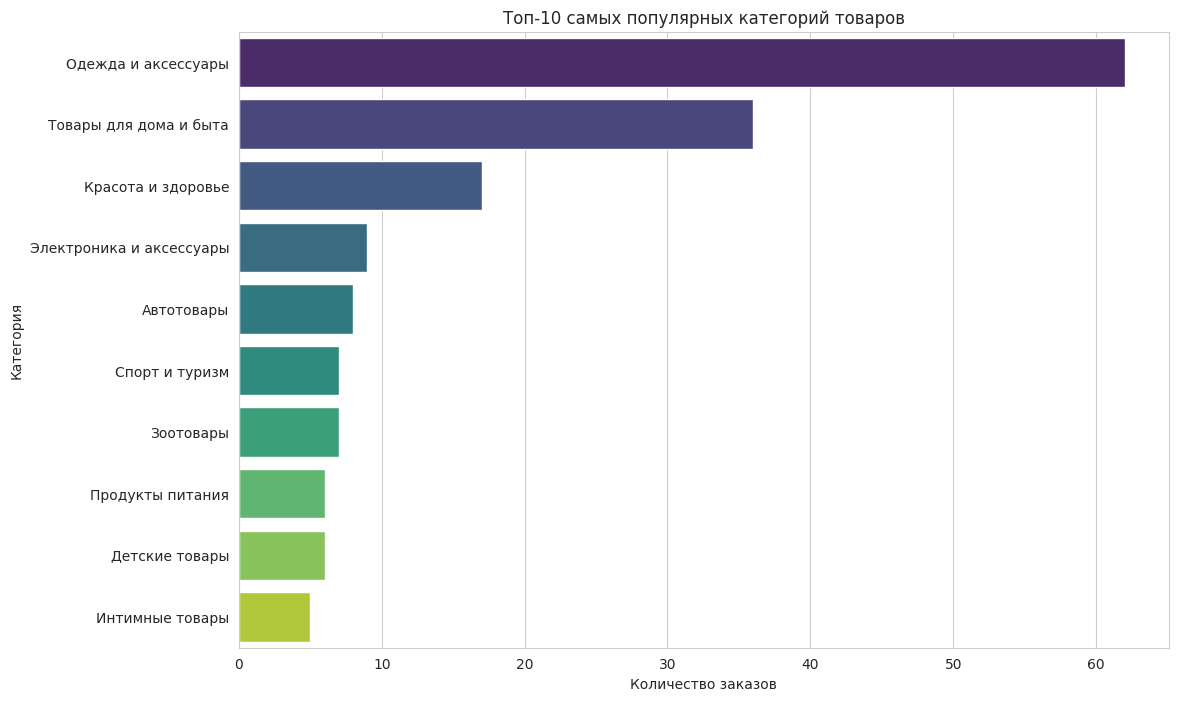

In [ ]:
# --- 2.1.1. Код для анализа категорий ---
popular_categories = df['Рубрики'].value_counts().reset_index()
popular_categories.columns = ['Категория', 'Количество заказов']
plt.figure(figsize=(12, 8))
sns.barplot(data=popular_categories.head(10), y='Категория', x='Количество заказов', palette='viridis')
plt.title('Топ-10 самых популярных категорий товаров')
plt.xlabel('Количество заказов'); plt.ylabel('Категория'); plt.show()

**Обоснованный вывод:**
> **Гипотеза полностью подтверждена.** График наглядно демонстрирует, что более 50% всех заказов приходится всего на две укрупненные категории: **"Одежда и аксессуары"** и **"Товары для дома и быта"**. Для поставщиков это означает, что данные ниши являются самыми крупными, но и самыми конкурентными.


#### **2.2. Выявление ключевых заказчиков**
**Задача:** Определить список заказчиков с самым широким ассортиментом закупаемых товаров.

In [ ]:
# --- 2.2.1. Код для выявления топ-заказчиков ---
top_assortment_customers = customers_df.sort_values(by=['unique_categories', 'orders_count', 'total_sum'], ascending=False)
print("--- Топ-10 заказчиков с самым широким ассортиментом и высокой активностью ---")
display(top_assortment_customers.head(10))

--- Топ-10 заказчиков с самым широким ассортиментом и высокой активностью ---


,Заказчик,total_sum,orders_count,unique_categories,first_order_date,last_order_date,days_active,purchase_frequency_days,Город поставки
60,2017248,150000.0,3,2,2022-08-12 16:36:00,2022-09-12 16:18:00,31,10.333333,Москва
45,1995624,600000.0,2,2,2023-04-13 15:44:00,2023-04-13 15:46:00,1,0.500000,Раменское
77,2048755,150000.0,2,2,2023-01-30 12:58:00,2023-04-26 12:46:00,86,43.000000,Краснодар
51,2002595,100000.0,2,2,2024-02-01 03:45:00,2024-02-01 03:47:00,1,0.500000,Улан-Удэ
111,2134133,200000.0,2,1,2023-07-06 11:32:00,2023-08-01 11:46:00,27,13.500000,Москва
179,2281339,100000.0,2,1,2024-12-02 17:15:00,2024-12-03 06:25:00,1,0.500000,Центральный федеральный округ
32,1957470,10000.0,2,1,2022-03-21 06:42:00,2022-03-21 06:42:00,1,0.500000,Архангельск
83,2068712,1000000.0,1,1,2022-12-16 06:51:00,2022-12-16 06:51:00,1,1.000000,Первоуральск
162,2219986,1000000.0,1,1,2024-04-09 11:11:00,2024-04-09 11:11:00,1,1.000000,Подольск
133,2171479,800000.0,1,1,2023-10-27 00:45:00,2023-10-27 00:45:00,1,1.000000,Казань


**Обоснованный вывод:**
> **Задача решена.** В таблице выше представлены наиболее перспективные клиенты. Критериями отбора служили широта ассортимента (`unique_categories`), количество (`orders_count`) и общая сумма (`total_sum`) заказов. Именно эти клиенты представляют наибольший интерес для развития сотрудничества.

#### **2.3. Анализ географии заказов**
**Задача:** Определить ключевые города и регионы, а также понять факторы выбора поставщика.

/tmp/ipython-input-26-2227455199.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_summary.head(10), y='Город поставки', x='total_sum', palette='plasma')


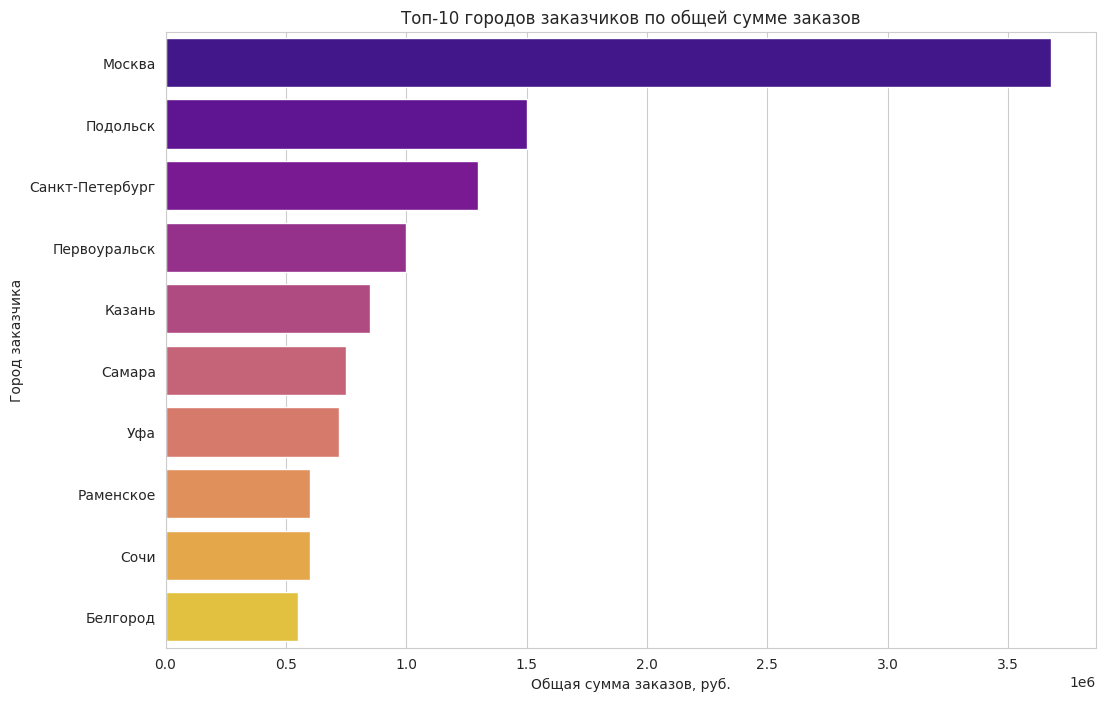

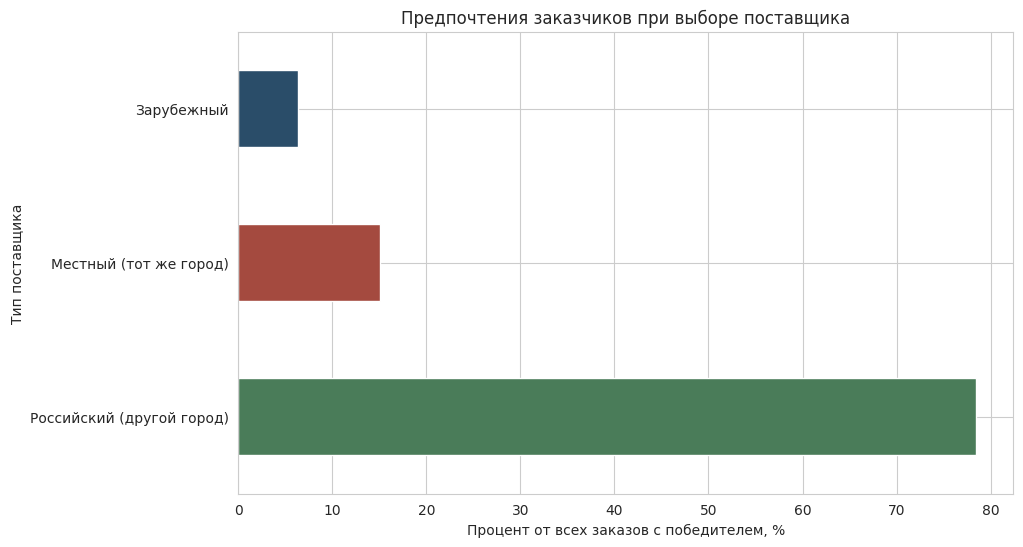

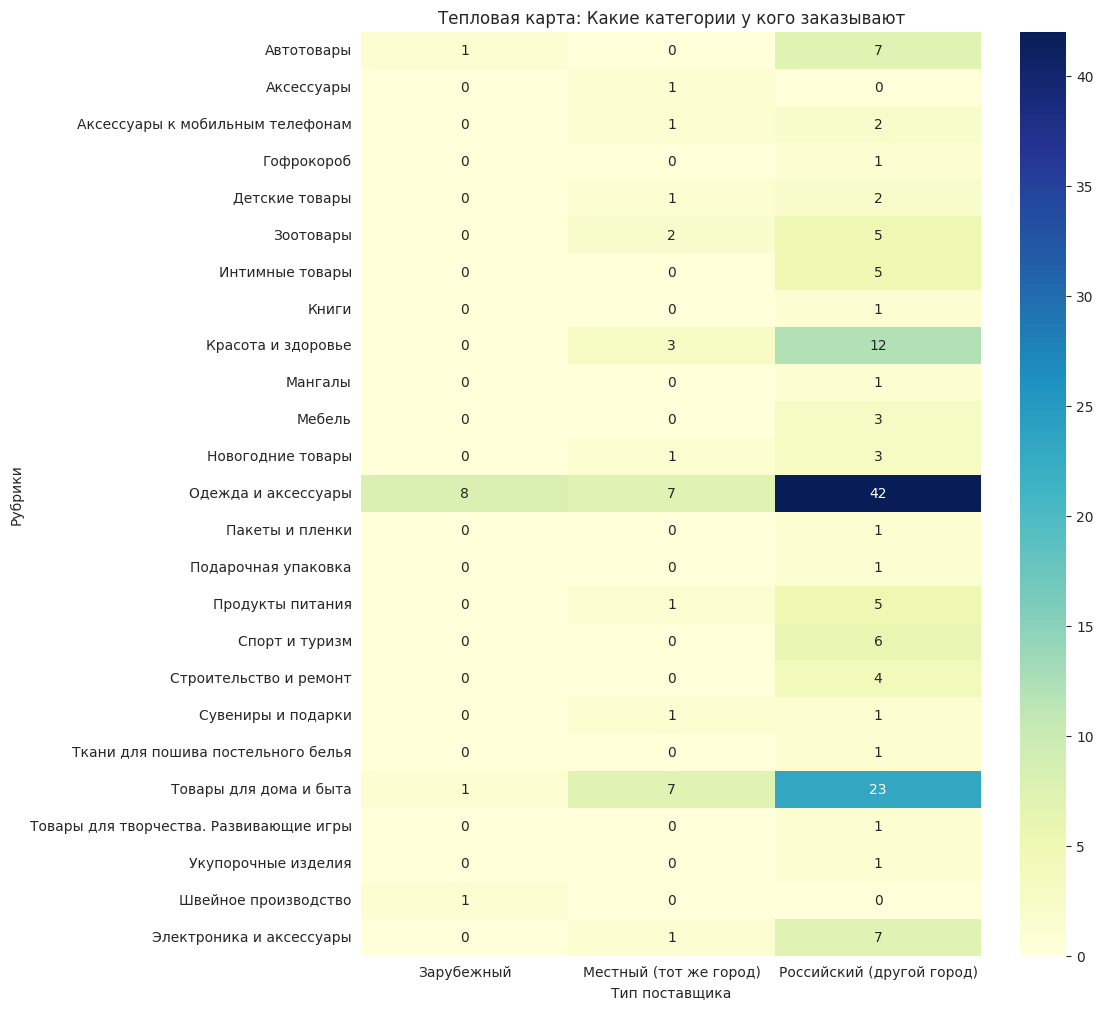

In [ ]:
# --- 2.3.1. Код для анализа городов и регионов ---
region_summary = customers_df.groupby('Город поставки')['total_sum'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=region_summary.head(10), y='Город поставки', x='total_sum', palette='plasma')
plt.title('Топ-10 городов заказчиков по общей сумме заказов'); plt.xlabel('Общая сумма заказов, руб.'); plt.ylabel('Город заказчика'); plt.show()

df_winners = df[df['Победившая компания'].notna() & df['Город победителя'].notna()].copy()
df_winners['Тип поставщика'] = df_winners.apply(get_supplier_type, axis=1)
supplier_choice_summary = df_winners['Тип поставщика'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6)); supplier_choice_summary.plot(kind='barh', color=['#4a7c59', '#a44a3f', '#2a4d69'])
plt.title('Предпочтения заказчиков при выборе поставщика'); plt.xlabel('Процент от всех заказов с победителем, %'); plt.show()

assortment_analysis = pd.crosstab(df_winners['Рубрики'], df_winners['Тип поставщика'])
plt.figure(figsize=(10, 12)); sns.heatmap(assortment_analysis, cmap="YlGnBu", annot=True, fmt='g')
plt.title('Тепловая карта: Какие категории у кого заказывают'); plt.show()

**Обоснованный вывод:**
>  Финансовая активность сосредоточена в **Москве**. Анализ выбора поставщиков доказывает, что **география не является ключевым фактором**. Тепловая карта демонстрирует четкую специализацию: за **производством и сырьем** обращаются за рубеж, за **массовыми товарами** — к поставщикам по всей России, а **местных** выбирают для нишевых или оперативных нужд. **Цена и уникальность ассортимента — главные факторы выбора.**

### **Часть 3: Сегментация клиентов и стратегические выводы**

#### **3.1. Построение сегментов методом кластеризации**
**Методология:** Для автоматического разделения клиентов на группы был применен алгоритм k-means. Для выбора оптимального количества кластеров был использован "метод локтя".

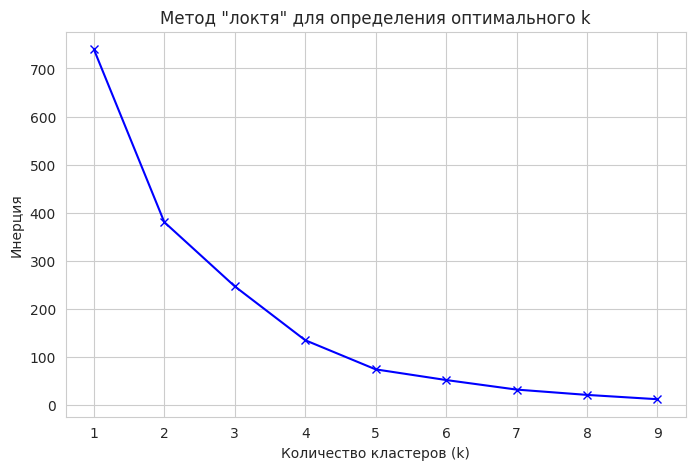

In [ ]:
# --- 3.1.1. Определение оптимального K (Метод локтя) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features_for_clustering = ['total_sum', 'orders_count', 'purchase_frequency_days', 'unique_categories']
X = customers_df[features_for_clustering]
scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)

inertia = []; K = range(1, 10)
for k in K: kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled); inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 5)); plt.plot(K, inertia, 'bx-')
plt.xlabel('Количество кластеров (k)'); plt.ylabel('Инерция'); plt.title('Метод "локтя" для определения оптимального k'); plt.show()

**Обоснованный вывод:**
> График "локтя" наглядно показывает, что после `k=4` скорость снижения инерции значительно замедляется. Это означает, что добавление новых кластеров уже не дает существенного прироста качества модели. **Поэтому в качестве оптимального было выбрано 4 кластера.**

In [ ]:
# --- 3.1.2. Финальная кластеризация и результат ---
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers_df['cluster'] = kmeans.fit_predict(X_scaled)
cluster_analysis = customers_df.groupby('cluster')[features_for_clustering].mean().sort_values(by='total_sum', ascending=False)
cluster_analysis['cluster_size'] = customers_df['cluster'].value_counts()
print(f"--- Анализ {optimal_k} сегментов (кластеров) ---"); display(cluster_analysis)

--- Анализ 4 сегментов (кластеров) ---


,total_sum,orders_count,purchase_frequency_days,unique_categories,cluster_size
cluster,,,,,
3,608333.333333,1.000000,1.000000,1.0,12
2,283333.333333,2.333333,3.777778,2.0,3
1,150000.000000,2.000000,43.000000,2.0,1
0,66953.893491,1.017751,1.068047,1.0,169



---

### **Анализ клиентских сегментов и рекомендации**

На основе данных о сумме, частоте и разнообразии заказов, все заказчики были разделены на 4 сегмента с помощью алгоритма кластеризации K-Means. Каждый сегмент демонстрирует уникальное покупательское поведение и требует особого подхода со стороны поставщиков.

---

#### **Сегмент 1: «Заказчики с единичными небольшими закупками» (Кластер 0)**

*   **Статистический портрет:**
    *   **Количество:** 169 клиентов (наиболее многочисленная группа).
    *   **Средняя сумма заказа:** ~67 000 руб.
    *   **Характеристики:** В среднем 1 заказ и 1 товарная категория.

*   **Описание сегмента:** Этот сегмент составляет основу клиентской базы. Это заказчики, которые совершают один пробный заказ на относительно небольшую сумму для решения конкретной, разовой задачи. Анализ показывает, что эти клиенты, как правило, не совершают повторных покупок.

*   **Рекомендации по работе:**
    *   **Цель:** Стимулирование повторной покупки.
    *   **Подход:** Взаимодействие с этим сегментом должно быть автоматизированным. Эффективны могут быть электронные рассылки со специальными предложениями на следующий заказ. Применение индивидуального подхода к этим клиентам экономически нецелесообразно.

---

#### **Сегмент 2: «Заказчики с единичными крупными закупками» (Кластер 3)**

*   **Статистический портрет:**
    *   **Количество:** 12 клиентов.
    *   **Средняя сумма заказа:** ~608 000 руб. (наивысший показатель).
    *   **Характеристики:** В среднем 1 заказ и 1 товарная категория.

*   **Описание сегмента:** Это небольшая, но очень ценная группа заказчиков, которые приносят значительную выручку с одной сделки. Они также действуют узкоспециализированно, но ищут товары на гораздо большую сумму.

*   **Рекомендации по работе:**
    *   **Цель:** Превращение разовой крупной сделки в долгосрочное сотрудничество.
    *   **Подход:** Требует индивидуального подхода. С момента появления заказа рекомендуется закрепить за клиентом персонального менеджера для обеспечения высокого качества исполнения сделки и обсуждения перспектив дальнейшей работы.

---

#### **Сегмент 3: «Активные повторные заказчики» (Кластер 2)**

*   **Статистический портрет:**
    *   **Количество:** 3 клиента.
    *   **Средняя сумма заказа:** ~283 000 руб.
    *   **Характеристики:** В среднем 2.3 заказа, 2 товарные категории, периодичность закупок – каждые 4 дня.

*   **Описание сегмента:** Эта малочисленная группа является самой активной на платформе. Эти заказчики не только совершают повторные покупки, но и делают это с высокой регулярностью, а также закупают товары из разных категорий. Это свидетельствует о высоком уровне доверия к площадке.

*   **Рекомендации по работе:**
    *   **Цель:** Сохранение и развитие отношений.
    *   **Подход:** Этим клиентам целесообразно предлагать особые условия: скидки, специальные предложения на основе их истории покупок. Важно анализировать их закупки и предлагать товары из смежных категорий.

---

#### **Сегмент 4: «Стабильные повторные заказчики» (Кластер 1)**

*   **Статистический портрет:**
    *   **Количество:** 1 клиент.
    *   **Средняя сумма заказа:** 150 000 руб.
    *   **Характеристики:** 2 заказа, 2 товарные категории, периодичность закупок – каждые 43 дня.

*   **Описание сегмента:** Этот клиент представляет собой образец стабильного заказчика. Он совершает повторные заказы на значительную сумму и делает это с предсказуемой периодичностью (примерно раз в полтора месяца).

*   **Рекомендации по работе:**
    *   **Цель:** Сохранение и изучение.
    *   **Подход:** Важно не только сохранить этого клиента, но и детально проанализировать его профиль и историю заказов, чтобы понять, как привлекать и развивать похожих заказчиков в будущем.

---


### **Часть 4: Альтернативная версия сегментации (по объему заказа)**

Чтобы обеспечить максимальную объективность и полноту анализа, была проведена альтернативная версия сегментации. В этой версии, в соответствии с первоначальной постановкой задачи, вместо признака `total_sum` (который содержит 40% вмененных данных) был использован на 100% достоверный, но более грубый категориальный признак **`Размер заказа`**.

**Цель этого шага:** Сравнить результаты двух подходов и понять, какой из них дает более осмысленные и полезные для бизнеса сегменты
(Для полноты картины добавим в итоговую таблицу среднюю сумму, хотя она и не будет участвовать в кластеризации).

In [ ]:
# --- 4.1. Подготовка данных для Версии 2 ---

# Создаем признак среднего размера заказа для каждого клиента
# 1 - Мелкий, 2 - Средний, 3 - Крупный
customers_df['avg_order_size'] = df.groupby('Заказчик')['Размер заказа (число)'].mean().values

# Определяем новый набор признаков для кластеризации
features_v2 = ['avg_order_size', 'orders_count', 'purchase_frequency_days', 'unique_categories']
X_v2 = customers_df[features_v2]

# Масштабируем новые данные
scaler_v2 = StandardScaler()
X_scaled_v2 = scaler_v2.fit_transform(X_v2)

print("--- Данные для альтернативной сегментации готовы ---")

--- Данные для альтернативной сегментации готовы ---


In [ ]:
# --- 4.2. Проведение кластеризации (Версия 2) ---

# Используем то же количество кластеров (k=4) для честного сравнения
optimal_k = 4
kmeans_v2 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Создаем НОВЫЙ столбец для кластеров, чтобы не перезаписать старый
customers_df['cluster_v2_by_size'] = kmeans_v2.fit_predict(X_scaled_v2)

# Анализируем новые кластеры
cluster_analysis_v2 = customers_df.groupby('cluster_v2_by_size')[features_v2].mean()
cluster_analysis_v2['cluster_size'] = customers_df['cluster_v2_by_size'].value_counts()

# Важно: для полноты картины добавим в итоговую таблицу среднюю сумму, хотя она и не участвовала в кластеризации
cluster_analysis_v2['avg_total_sum_info'] = customers_df.groupby('cluster_v2_by_size')['total_sum'].mean()


print(f"--- Анализ {optimal_k} сегментов (Версия 2, по объему) ---")
display(cluster_analysis_v2.sort_values(by='avg_order_size', ascending=False))

--- Анализ 4 сегментов (Версия 2, по объему) ---


,avg_order_size,orders_count,purchase_frequency_days,unique_categories,cluster_size,avg_total_sum_info
cluster_v2_by_size,,,,,,
3,2.300000,1.000000,1.000000,1.0,50,201013.800000
2,1.666667,2.333333,3.777778,2.0,3,283333.333333
1,1.500000,2.000000,43.000000,2.0,1,150000.000000
0,0.919847,1.022901,1.087786,1.0,131,65378.000000


### **Часть 5: Сравнение двух версий сегментации**

Для того чтобы понять, как изменилось распределение клиентов, построим матрицу пересечения двух кластеризаций.

--- Матрица пересечения кластеров ---
Строки: Версия 1 (по Сумме), Столбцы: Версия 2 (по Объему)


cluster_v2_by_size,0,1,2,3
cluster_v1_by_sum,,,,
0,129,0,0,40
1,0,1,0,0
2,0,0,3,0
3,2,0,0,10


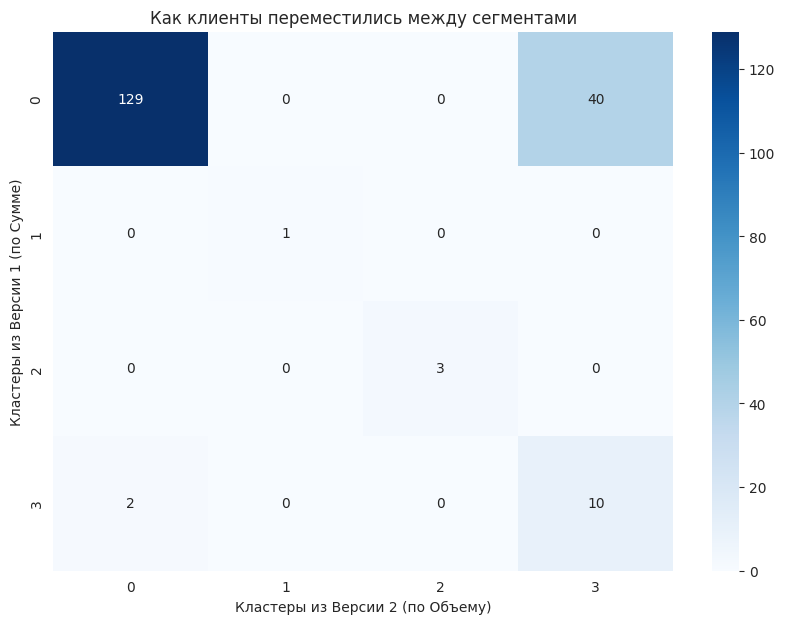

In [ ]:
# --- 5.1. Сравнение результатов ---

# Переименуем столбцы для ясности
customers_df.rename(columns={'cluster': 'cluster_v1_by_sum'}, inplace=True)

# Строим матрицу пересечения
cross_tab = pd.crosstab(customers_df['cluster_v1_by_sum'], customers_df['cluster_v2_by_size'])

print("--- Матрица пересечения кластеров ---")
print("Строки: Версия 1 (по Сумме), Столбцы: Версия 2 (по Объему)")
display(cross_tab)

# Визуализация
plt.figure(figsize=(10, 7))
sns.heatmap(cross_tab, annot=True, fmt='g', cmap='Blues')
plt.title('Как клиенты переместились между сегментами')
plt.ylabel('Кластеры из Версии 1 (по Сумме)')
plt.xlabel('Кластеры из Версии 2 (по Объему)')
plt.show()

### **Итоговый вывод по сравнению двух подходов**

Сравнение двух версий сегментации, основанных на разных признаках, позволяет сделать объективные выводы о каждом из подходов.

1.  **Потеря информации о реальной сумме заказов в Версии 2:**
    *   **Наблюдение:** Матрица пересечения показывает, что 12 заказчиков, которые в Версии 1 были определены как самые крупные по сумме заказа (со средним чеком **608 тыс. руб.**), в Версии 2 были распределены по-другому. 10 из них попали в общую группу со средним чеком всего **201 тыс. руб.**
    *   **Вывод:** Это означает, что подход, основанный на категориальном признаке "Объем" ("Мелкий", "Крупный"), не смог отличить заказ на 1 млн руб. от заказа на 100 тыс. руб., если оба были помечены как "Крупные". В результате этого подхода теряется важная информация о реальной сумме, которую потратил клиент.

2.  **Надежное определение клиентов с повторными заказами в обеих версиях:**
    *   **Наблюдение:** 4 клиента, которые совершали повторные заказы, были безошибочно выделены обеими моделями в отдельные небольшие группы (кластеры `1` и `2` в Версии 2).
    *   **Вывод:** Это подтверждает, что повторные покупки являются очень сильным и стабильным признаком. Этот тип поведения определяется надежно, независимо от того, как мы измеряем объем — по сумме или по категориальной метке.

#### **Финальная рекомендация по выбору метода**

Оба подхода имеют свои сильные и слабые стороны:

*   **Версия 2 (по 'Объему')** хороша тем, что использует только исходные данные без каких-либо допущений. Она надежно определяет клиентов, которые совершают повторные заказы. Ее недостаток — она "усредняет" клиентов с очень разной суммой покупки.

*   **Версия 1 (по 'Сумме')**, несмотря на использование заполненных данных для 40% заказов, оказывается более полезной на практике. Она позволяет получить более подробное и понятное разделение клиентов по суммам, которые они тратят, безошибочно выделяя заказчиков с необычно большими покупками.

Для дальнейших выводов будут использованы результаты кластеризации по сумме закупок.


---
### Итоговые стратегические выводы

Комплексный анализ данных позволил сформулировать три ключевых вывода о работе на данной торговой площадке:

1.  Большинство сделок — разовые. Анализ показал, что подавляющее большинство заказчиков (181 из 185) совершают только одну покупку. Это указывает на то, что заказчики редко становятся постоянными. Поставщикам следует сосредоточиться на постоянном привлечении новых клиентов, а не рассчитывать на долгосрочную работу с существующими.

2.  Заказчики действуют узкоспециализированно. Подавляющее число клиентов ищут товары в одной конкретной категории. Категория «Одежда и аксессуары» является наиболее востребованной. Успешная стратегия для поставщика — стать специалистом в своей нише, предлагая большой выбор товаров внутри одной популярной категории.

3.  Географическое положение не является решающим фактором. Анализ показал, что почти 80% всех сделок являются межрегиональными. Это означает, что заказчики готовы работать с поставщиками из других городов ради лучшей цены или ассортимента. Следовательно, поставщики конкурируют не только с компаниями из своего города, но и со всей страны, поэтому стоимость и надежность доставки становятся одними из ключевых факторов успеха.
---